In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/PSOG/itrp/itrpnet')

from trainer import TCGAPreTrainer

In [3]:
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    return dfd
    
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
df_tpm_normal = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.NORMAL.TABLE'))

tcga_label = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
mutation = tcga_label[['tmb', 'cnv', 'msi']] #.fillna(0)
df_cancer = tcga_label[['cancer_type']]

df_tmb = mutation[['tmb']]
df_msi = mutation[['msi']]
df_cnv= mutation[['cnv']]
df_ctc = tcga_label[['cancer_type']]

df_msi = onehot(df_msi.msi)
df_ctc = onehot(df_ctc.cancer_type)
df_rps = onehot(tcga_label['treatment_outcome'])
df_ost = np.log10(tcga_label[['os_time']]+1)
df_oss = onehot(tcga_label.os_status)

df_pft = np.log10(tcga_label[['pfi_time']]+1)
df_pfs = onehot(tcga_label.pfi_status)

In [4]:

tasks = {'msi': df_msi, 
         'tmb': df_tmb, 
         'cnv':df_cnv, 
         'ctc':df_ctc, 
         'rps':df_rps, 
         'ost':df_ost,
         'oss':df_oss,
         'pft':df_pft,
         'pfs':df_pfs}


tasks_type_map = {'msi': 'c', 'tmb': 'r', 
                  'cnv':'r', 'ctc':'c', 
                  'rps':'c', 'ost':'r', 
                  'oss':'c', 'pft':'r', 'pfs':'c'}

In [5]:
tasks = {'tmb': df_tmb}

In [6]:
for task_name, df_task  in tasks.items():
    task_type = tasks_type_map[task_name]

In [7]:
test_idx = df_cancer.groupby('cancer_type').apply(lambda x:x.sample(frac=0.2, random_state=1).index.tolist()).tolist()
test_idx = list(chain(*test_idx))
train_idx = df_cancer[~df_cancer.index.isin(test_idx)].index

df_task_train = df_task.loc[train_idx]
df_tpm_train = df_tpm.loc[train_idx]

df_task_test = df_task.loc[test_idx]
df_tpm_test = df_tpm.loc[test_idx]

print(len(df_tpm_train), len(df_tpm_test), len(df_tpm_normal))

In [8]:
# ## parameters
# device='cuda'
# lr = 1e-5
# weight_decay = 1e-4
# epochs = 10
# batch_size = 64
# embed_dim=32
# triplet_margin=1.
# K = 500

# task_loss_weight = 1.
# task_dense_layer = [24, 16]
# task_batch_norms = False

# encoder='transformer'
# transformer_dim = 256
# transformer_num_layers = 4


# #encoder= 'mlp'
# mlp_dense_layers = [512, 256, 128]

T = TCGAPreTrainer(df_tpm_normal, encoder='mlp', #mlp_dense_layers = [128, 64],
                   epochs=50, lr = 1e-3, triplet_margin = 1., K = 500, run_name_prefix = 'T')

In [9]:
T.train(df_tpm_train, df_task_train, task_name, task_type, df_tpm_test, df_task_test)

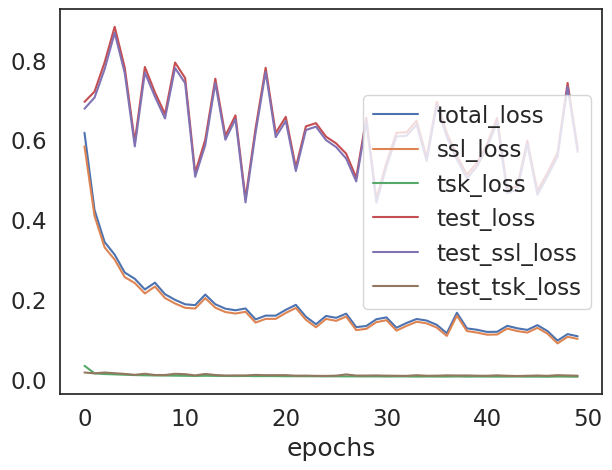

Epochs completed:   0%|            0/500 [00:00]

In [10]:
dfc = df_cancer.cancer_type.apply(lambda x:x.replace('TCGA-', '')).to_frame()
msi = tcga_label[['msi']]
cnv = tcga_label.cnv.clip(-1, 0.5).to_frame(name='cnv')

l1 = tcga_label[['race', 'vital_status', 'treatment_outcome']].fillna('NaN')
l2 = np.log10(tcga_label[['pfi_time', 'os_time']]+1)
l3 = tcga_label[['gender', 'age',]]
df_label = dfc.join(df_tmb).join(cnv).join(msi).join(l1).join(l2).join(l3)
label_col = ['cancer_type', 'tmb', 'cnv', 'msi', 'race', 'vital_status',
       'treatment_outcome', 'pfi_time', 'os_time', 'gender', 'age']

label_type = ['c', 'r', 'r', 'c',  'c', 'c', 'c',  'r',  'r', 'c', 'r',]
T.plot_embed(df_tpm_test, df_label.loc[df_tpm_test.index], label_type, s=5,figsize=(5,5))

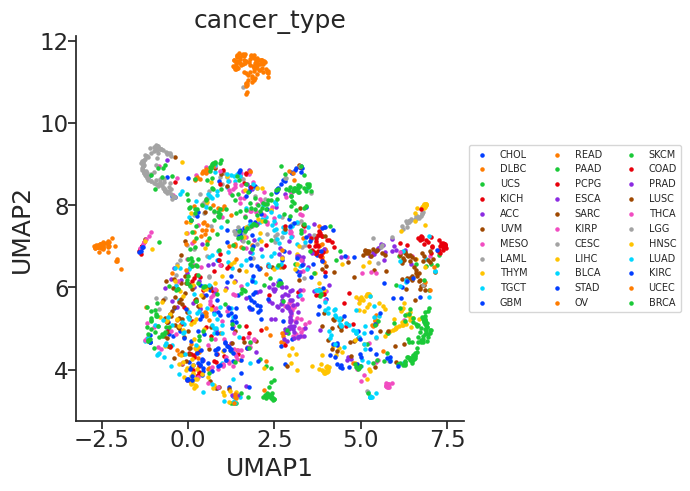

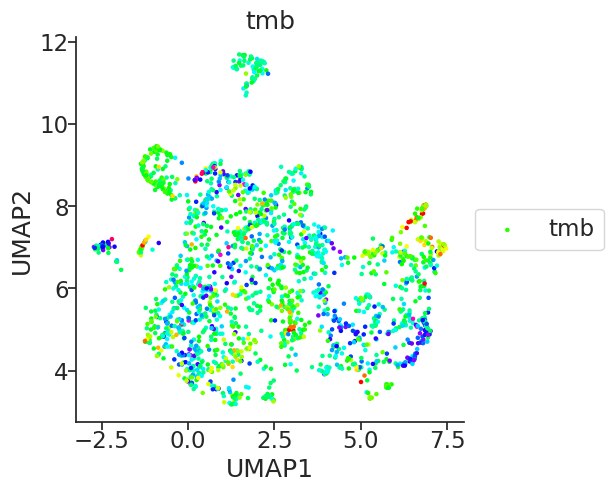

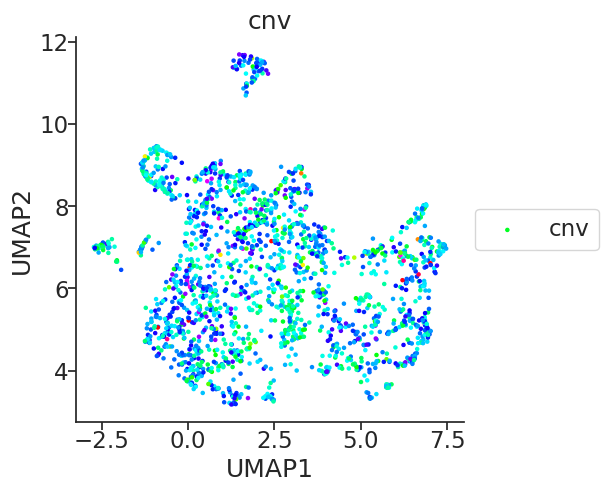

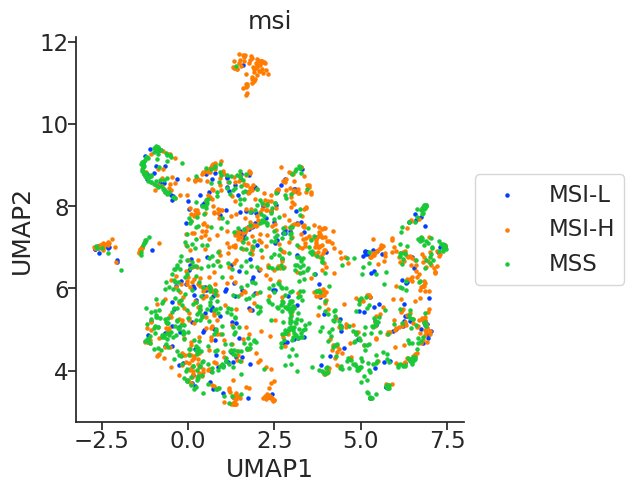

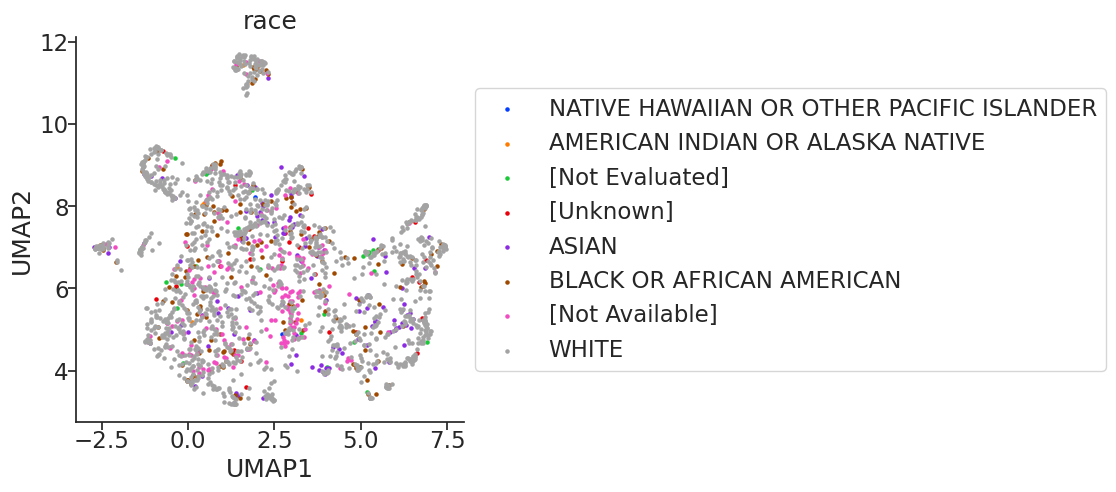

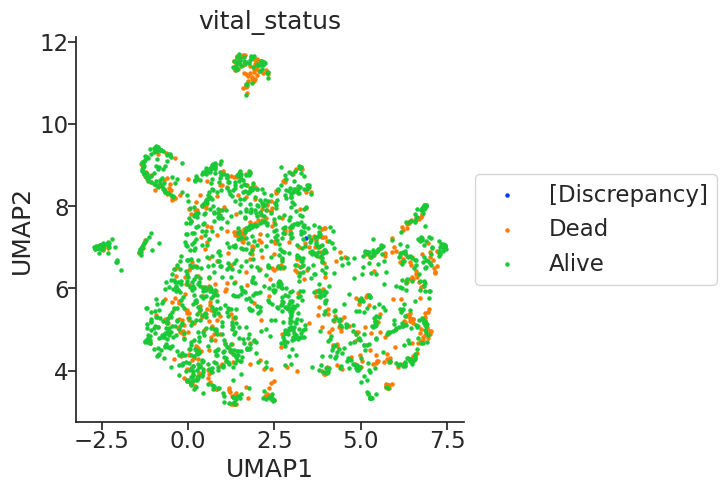

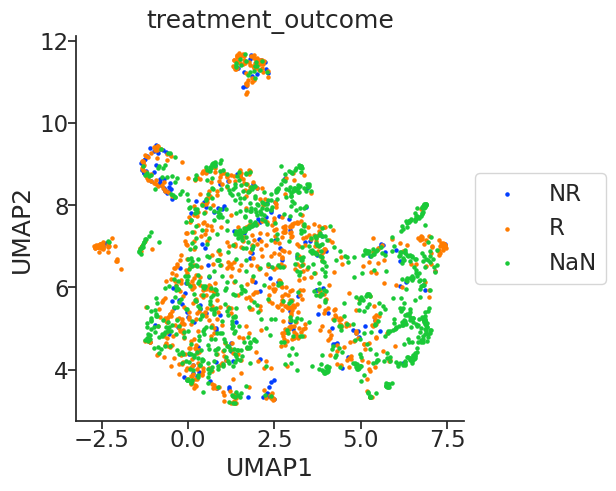

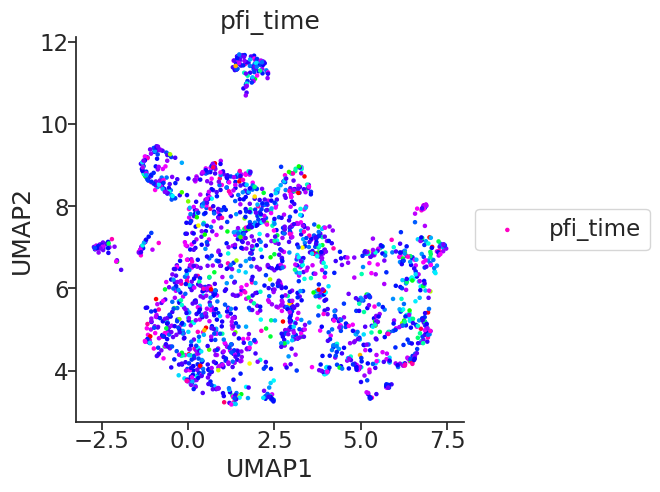

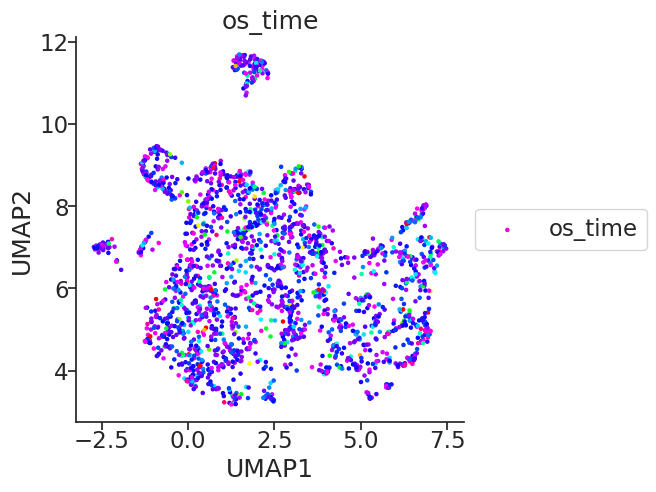

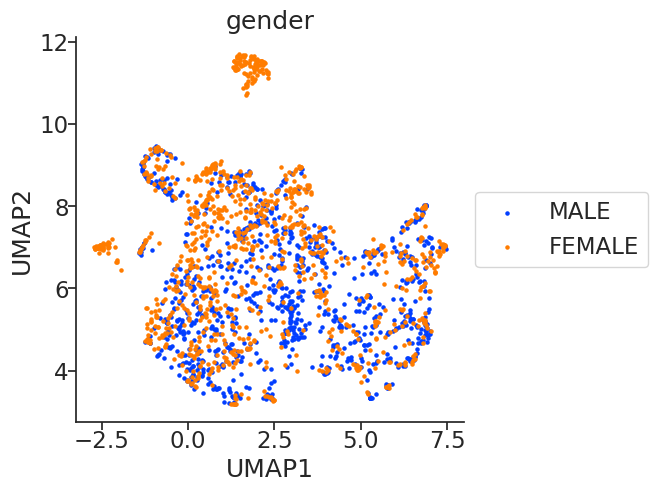

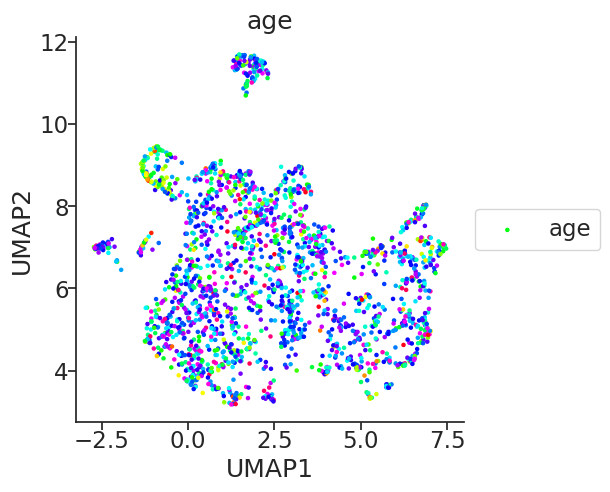

Epochs completed:   0%|            0/500 [00:00]

In [11]:
### make prediction & plot on ITRP
itrp_x = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_meta = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
itrp_meta['response_label'] = itrp_meta['Freeman_response']
itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']
itrp_y = itrp_meta[['response_label']]
itrp_c = itrp_meta[['cohort']]
itrp_meta.groupby('cohort')['response_label'].value_counts().unstack().T

label_col = ['cohort','response_label','RECIST','Alive (Y=1, No=0)', 'Overall_survival']
df_label = itrp_meta[label_col]
label_type = ['c', 'c', 'c', 'c', 'r']

T.plot_embed(itrp_x, df_label, label_type, s=20, figsize=(5,5))

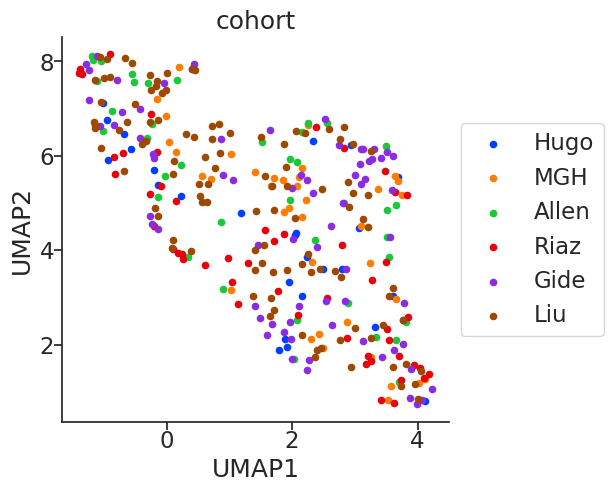

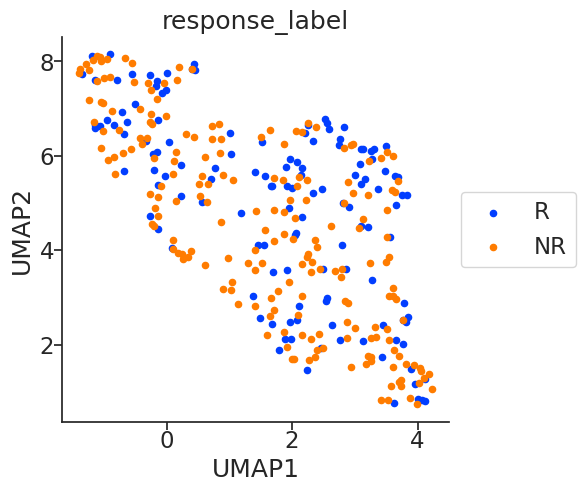

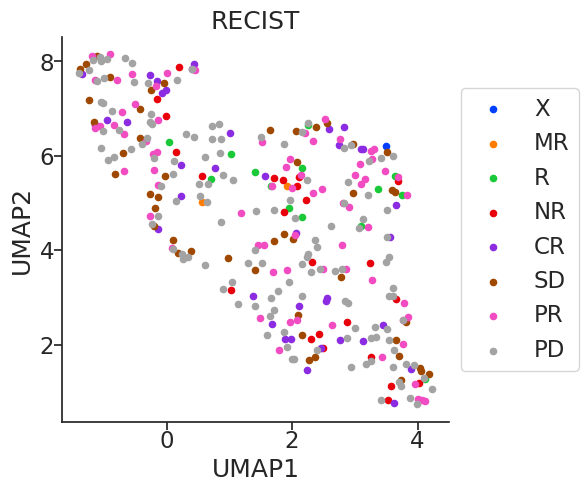

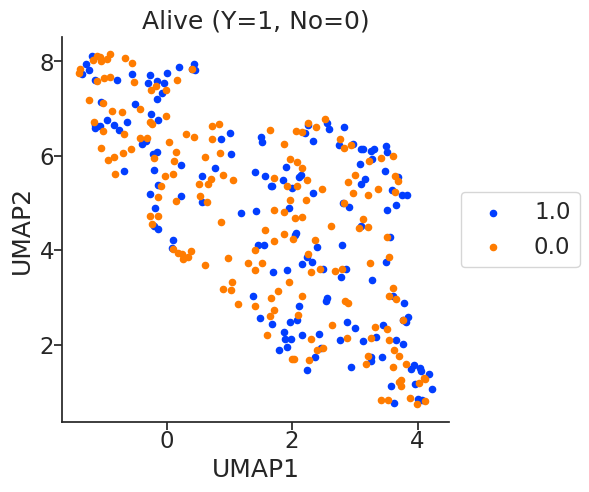

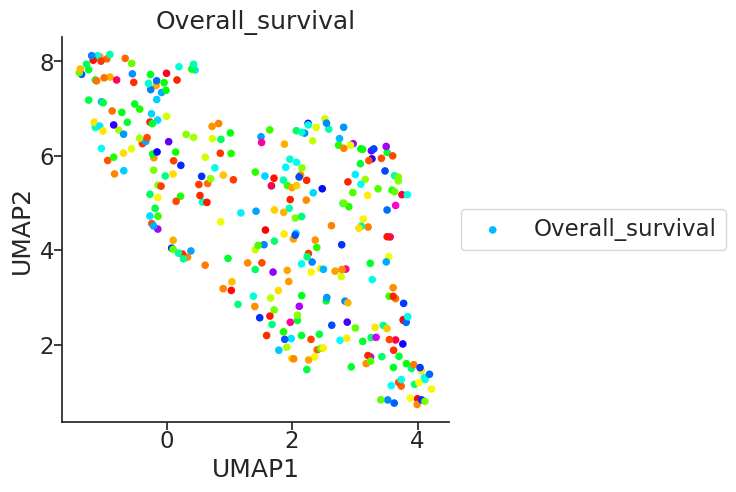

In [12]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [13]:
import sys
sys.path.insert(0, '/home/was966/Research/PSOG/itrp/itrpnet')

from trainer import TCGAPreTrainer

In [14]:
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    return dfd
    
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
df_tpm_normal = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.NORMAL.TABLE'))

tcga_label = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
mutation = tcga_label[['tmb', 'cnv', 'msi']] #.fillna(0)
df_cancer = tcga_label[['cancer_type']]

df_tmb = mutation[['tmb']]
df_msi = mutation[['msi']]
df_cnv= mutation[['cnv']]
df_ctc = tcga_label[['cancer_type']]

df_msi = onehot(df_msi.msi)
df_ctc = onehot(df_ctc.cancer_type)
df_rps = onehot(tcga_label['treatment_outcome'])
df_ost = np.log10(tcga_label[['os_time']]+1)
df_oss = onehot(tcga_label.os_status)

df_pft = np.log10(tcga_label[['pfi_time']]+1)
df_pfs = onehot(tcga_label.pfi_status)

In [15]:

tasks = {'msi': df_msi, 
         'tmb': df_tmb, 
         'cnv':df_cnv, 
         'ctc':df_ctc, 
         'rps':df_rps, 
         'ost':df_ost,
         'oss':df_oss,
         'pft':df_pft,
         'pfs':df_pfs}


tasks_type_map = {'msi': 'c', 'tmb': 'r', 
                  'cnv':'r', 'ctc':'c', 
                  'rps':'c', 'ost':'r', 
                  'oss':'c', 'pft':'r', 'pfs':'c'}

In [16]:
tasks = {'tmb': df_tmb}

In [17]:
for task_name, df_task  in tasks.items():
    task_type = tasks_type_map[task_name]

In [18]:
test_idx = df_cancer.groupby('cancer_type').apply(lambda x:x.sample(frac=0.2, random_state=1).index.tolist()).tolist()
test_idx = list(chain(*test_idx))
train_idx = df_cancer[~df_cancer.index.isin(test_idx)].index

df_task_train = df_task.loc[train_idx]
df_tpm_train = df_tpm.loc[train_idx]

df_task_test = df_task.loc[test_idx]
df_tpm_test = df_tpm.loc[test_idx]

print(len(df_tpm_train), len(df_tpm_test), len(df_tpm_normal))

In [19]:
# ## parameters
# device='cuda'
# lr = 1e-5
# weight_decay = 1e-4
# epochs = 10
# batch_size = 64
# embed_dim=32
# triplet_margin=1.
# K = 500

# task_loss_weight = 1.
# task_dense_layer = [24, 16]
# task_batch_norms = False

# encoder='transformer'
# transformer_dim = 256
# transformer_num_layers = 4


# #encoder= 'mlp'
# mlp_dense_layers = [512, 256, 128]

T = TCGAPreTrainer(df_tpm_normal, encoder='mlp', #mlp_dense_layers = [128, 64],
                   epochs=50, lr = 1e-4, triplet_margin = 1., K = 500, run_name_prefix = 'T')

In [20]:
T.train(df_tpm_train, df_task_train, task_name, task_type, df_tpm_test, df_task_test)